In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import random 
import itertools


In [2]:
import pandas as pd
df = pd.read_csv("airbus.csv", delimiter=',', skiprows=0, low_memory=False)

cmap = plt.cm.tab20  # define the colormap
cmap = [cmap(i) for i in range(20)]

cmap2 = plt.cm.tab20b  # define the colormap
cmap2 = [cmap2(i) for i in range(20)]


for i in cmap2:
    cmap.append(i)
    

In [4]:
print(df.iloc[:,2].sum())


x1=np.linspace(-0.5,-0.01,10)
x2=np.linspace(0.01,0.5,10)


x1=[x1 for x1 in x1]
x2=[x2 for x2 in x2]

for i in x2:
    x1.append(i)
X=x1
def SB(j):
    if j<11:
        return 22000*(j-1)/9
    else:
        return 22000*(20-j)/9
    
    


57897


In [5]:
model = AbstractModel()
model.N =Param ( mutable=True)
model.i = RangeSet(30)
model.j = RangeSet(20)

model.shift =Param (default=0, mutable=True) 


def rule_initD(model,i):
    return df.iloc[i-1,2]
model.W =Param (model.i, default=rule_initD, mutable=True) 

def rule_initT(model,i):
    return df.iloc[i-1,1]
model.T =Param (model.i, default=rule_initT, mutable=True) 


model.x = Var(model.i,model.j,within=Binary)

def rule_Sbound(model,j):
    if j<11:
        return (0,22000*(j-1)/9)
    else:
        return (0,22000*(20-j)/9)

model.s = Var(model.j,bounds=rule_Sbound,within=NonNegativeReals)
model.CG = Var(within=Reals)


def rule_C1(model,j):
    return sum(model.x[i,j]*model.T[i] for i in model.i)<=2
model.C1=Constraint(model.j, rule=rule_C1)

def rule_C2(model,i):
    return sum(model.x[i,j] for j in model.j)<=1
model.C2=Constraint(model.i, rule=rule_C2)

def rule_C3(model,j):
    if j<11:
        return model.s[j]==sum(model.W[i]*model.x[i,jj] for i in model.i for jj in model.j if jj<=j)
    else:
        return model.s[j]==sum(model.W[i]*model.x[i,jj] for i in model.i for jj in model.j if jj>=j )
model.C3=Constraint(model.j, rule=rule_C3)


def rule_C4(model):
    return -120000*0.05+sum(model.W[i]*model.x[i,j]*X[j-1] for i in model.i for j in model.j)<= 0.2* sum(model.W[i]*model.x[i,j] for i in model.i for j in model.j)
model.C4=Constraint(rule=rule_C4)

def rule_C5(model):
    return -120000*0.05+sum(model.W[i]*model.x[i,j]*X[j-1] for i in model.i for j in model.j)>= (-0.1+model.shift)* sum(model.W[i]*model.x[i,j] for i in model.i for j in model.j)
model.C5=Constraint(rule=rule_C5)

def rule_C6(model):
    return sum(model.W[i]*model.x[i,j] for i in model.i for j in model.j)<=40000
model.C6=Constraint(rule=rule_C6)

def rule_of(model):
    return sum(model.W[i]*model.x[i,j] for i in model.i for j in model.j)
    
model.obj = Objective(rule=rule_of, sense=maximize)

In [6]:
#model.N=43
opt = SolverFactory('gurobi')
opt.options["mipgap"] = 0.05
instance = model.create_instance()
'''for k in instance.k:
    instance.u[k,1].fix(1)'''
#instance = model.create_instance('AE.dat')

'for k in instance.k:\n    instance.u[k,1].fix(1)'

In [7]:
#instance.y[1,1].fix(0)
results = opt.solve(instance) # solves and updates instance
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print('feasible')
elif (results.solver.termination_condition == TerminationCondition.infeasible):
    print('infeasible')
else:
    print ('Solver Status:',  results.solver.status)

feasible


In [8]:
x=-120000*0.05+sum(value(instance.W[i]*instance.x[i,j]*X[j-1]) for i in instance.i for j in instance.j)
y=sum(value(instance.W[i]*instance.x[i,j]) for i in instance.i for j in instance.j)
print(x/y)

-0.09911130008976489


([<matplotlib.axis.YTick at 0x7fa701e61a50>,
 [Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4'),
  Text(0, 5, '5'),
  Text(0, 6, '6'),
  Text(0, 7, '7'),
  Text(0, 8, '8'),
  Text(0, 9, '9'),
  Text(0, 10, '10'),
  Text(0, 11, '11'),
  Text(0, 12, '12'),
  Text(0, 13, '13'),
  Text(0, 14, '14'),
  Text(0, 15, '15'),
  Text(0, 16, '16'),
  Text(0, 17, '17'),
  Text(0, 18, '18'),
  Text(0, 19, '19'),
  Text(0, 20, '20')])

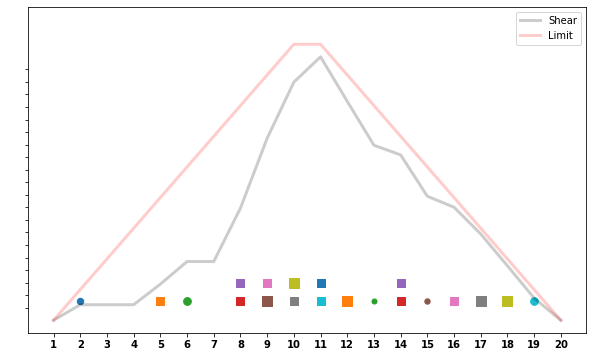

In [9]:
MV=['^','s','o']
fig = plt.figure(figsize=(10,6))

verts = list(zip([-1000.,1000.,1000.,-1000],[-1000.,-1000.,1000.,1000]))
#ax.scatter([0.5,1.0],[1.0,2.0], marker=(verts,0))

for j in instance.j:
    plt.scatter(j,1,s=100, c='w',facecolor='none', marker=verts)

    
for j in instance.j:
    iter=0
    for i in instance.i:
        if value(instance.x[i,j])>0.1:
            iter+=1.5
            plt.scatter(j,iter,s=value(instance.W[i])/30, marker=MV[value(instance.T[i])] )
SS=[value(instance.s[j])/1000 for j in instance.j]
            
plt.plot(range(1,21),SS,c='k',lw=3,alpha=0.2, label='Shear')

SMAX=[SB(j)/1000 for j in instance.j]
plt.plot(range(1,21),SMAX,c='r',lw=3,alpha=0.2, label='Limit')
plt.legend()

plt.ylim(-1,25)
XT=[str(i) for i in range(1,21)]
plt.xticks(range(1,21),XT, c='k', fontweight='bold')
plt.yticks(range(1,21),XT, c='w', fontweight='bold')
#plt.axis('off')

1
2
3
4
5
5


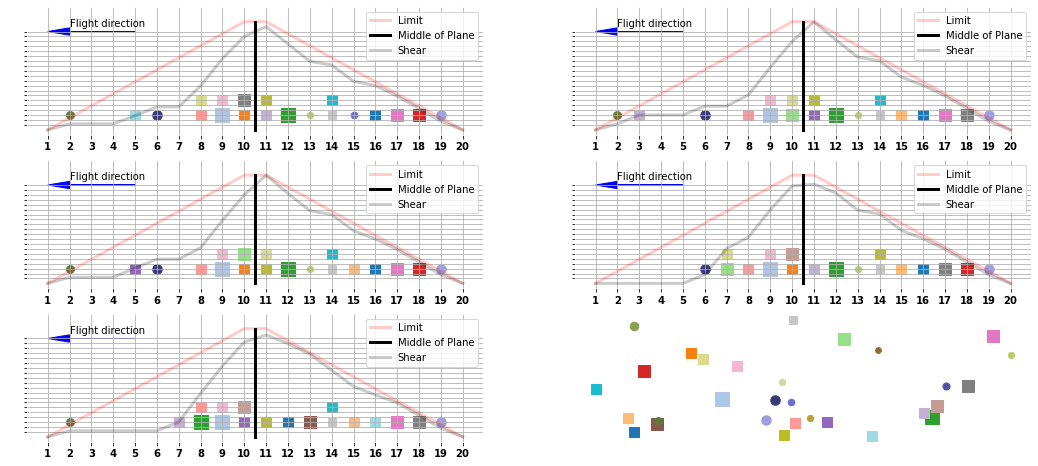

In [9]:
fig = plt.subplots(nrows=2, ncols=4,figsize=(18,8))
cell=0
for n in range(1,6,1):
    #plt.annotate("Flight direction", xy=(4, 20000), xytext=(4, 20000),arrowprops=dict(arrowstyle="->"))

    plt.rc('axes',edgecolor='w')

    instance.shift=(n-1)*0.004
    results = opt.solve(instance) # solves and updates instance

    cell+=1
    plt.subplot(3, 2, cell)
    plt.arrow(5, 20, -3, 0, head_width=1.5, head_length=1, fc='b', ec='b')
    plt.text(2, 21, s='Flight direction')

    for j in instance.j:
        iter=0
        for i in instance.i:
            if value(instance.x[i,j])>0.1:
                iter+=3
                plt.scatter(j,iter,s=value(instance.W[i])/20, color=cmap[i-1], marker=MV[value(instance.T[i])] )
    SS=[value(instance.s[j])/1000 for j in instance.j]
    plt.plot(range(1,21),SMAX,c='r',lw=3,alpha=0.2, label='Limit')
    plt.plot([10.5,10.5],[0,22],c='k',lw=3,alpha=1, label='Middle of Plane')
    plt.plot(range(1,21),SS,c='k',lw=3,alpha=0.2, label='Shear')
    plt.legend()

    plt.ylim(-1,25)
    XT=[str(i) for i in range(1,21)]
    plt.xticks(range(1,21),XT, c='k', fontweight='bold')
    plt.yticks(range(1,21),XT, c='w')
    plt.grid()
    print(n)
    

cell+=1
plt.subplot(3, 2, cell)
plt.rc('axes',edgecolor='w')

for i in instance.i:
    x=-1+2*np.random.rand()
    y=-1+2*np.random.rand()
    plt.scatter(5000*x,5000*y,s=value(instance.W[i])/20, color=cmap[i-1], marker=MV[value(instance.T[i])] )
#plt.ylim(-1,25)
XT=[str(i) for i in range(1,21)]
plt.grid()
plt.axis('off')
print(n)
plt.savefig('Airbus Cargo.png',dpi=800)

1
2
3
4
5
6


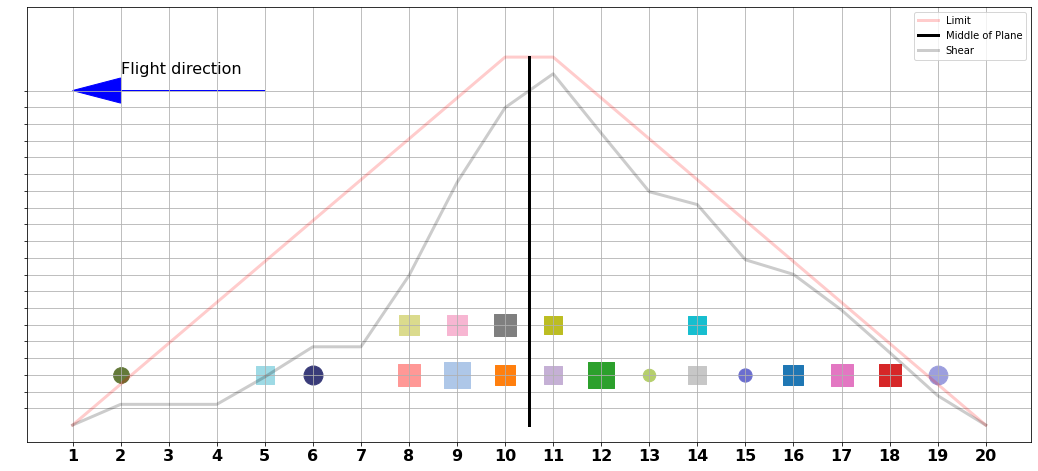

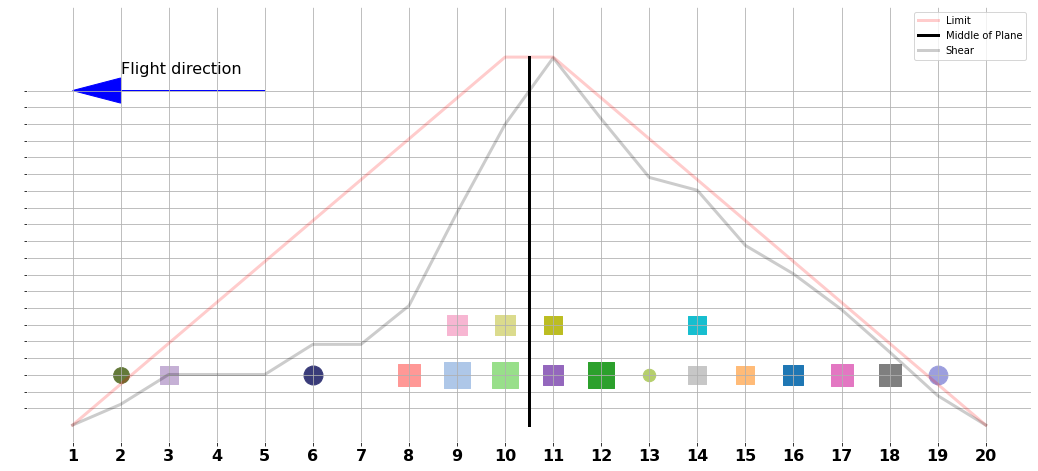

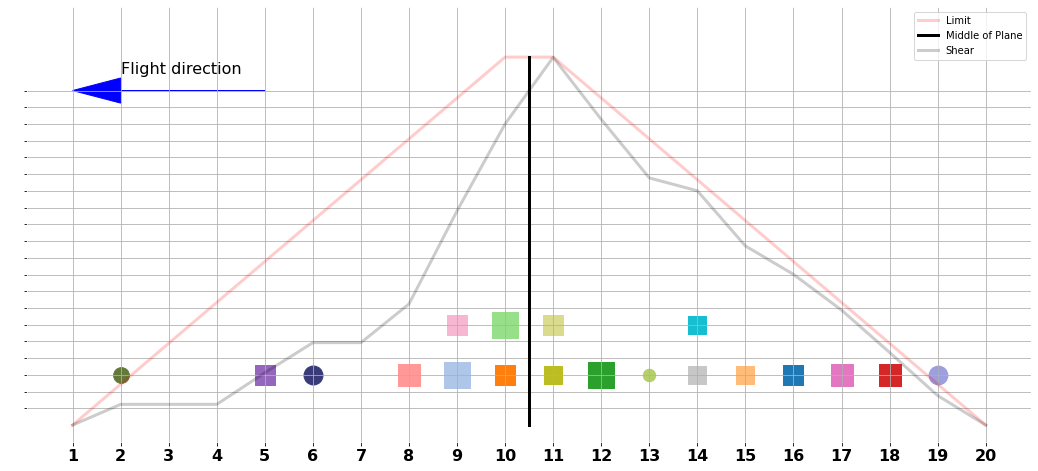

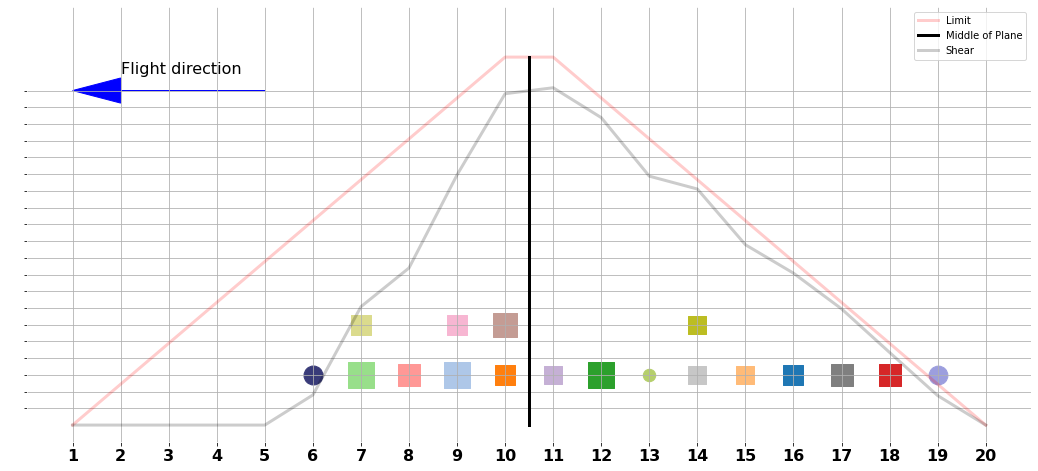

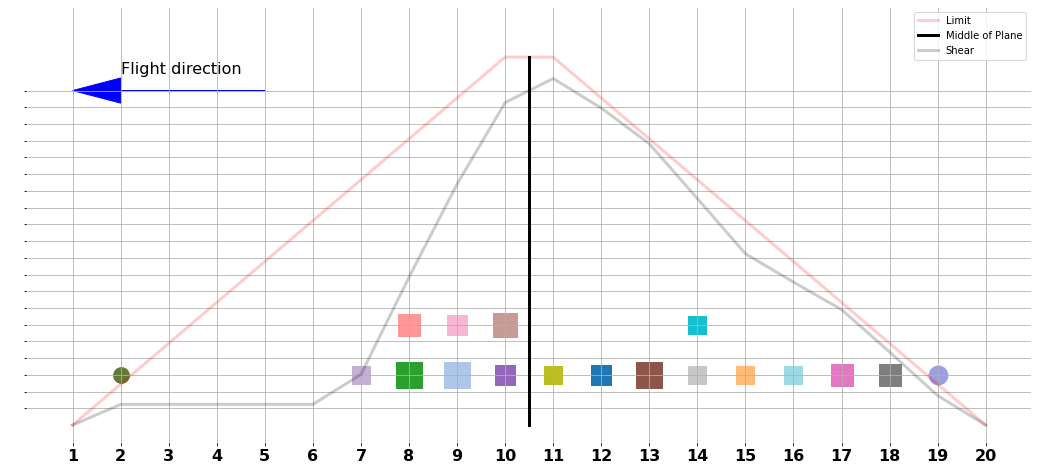

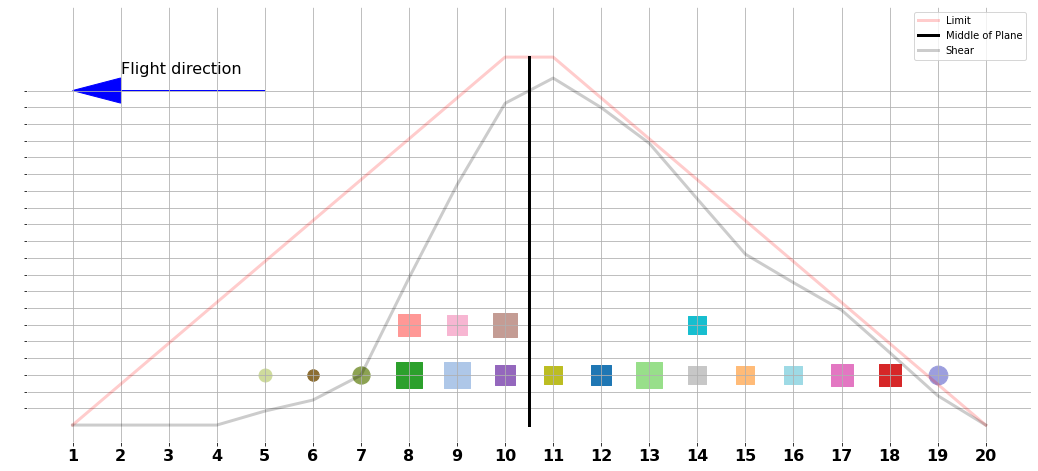

In [10]:
cell=0
for n in range(1,7,1):
    fig = plt.subplots(figsize=(18,8))

    #plt.annotate("Flight direction", xy=(4, 20000), xytext=(4, 20000),arrowprops=dict(arrowstyle="->"))

    plt.rc('axes',edgecolor='w')

    instance.shift=(n-1)*0.004
    results = opt.solve(instance) # solves and updates instance

    cell+=1
    plt.arrow(5, 20, -3, 0, head_width=1.5, head_length=1, fc='b', ec='b')
    plt.text(2, 21, s='Flight direction', fontsize=16)

    for j in instance.j:
        iter=0
        for i in instance.i:
            if value(instance.x[i,j])>0.1:
                iter+=3
                plt.scatter(j,iter,s=value(instance.W[i])/5, color=cmap[i-1], marker=MV[value(instance.T[i])] )
    SS=[value(instance.s[j])/1000 for j in instance.j]
    plt.plot(range(1,21),SMAX,c='r',lw=3,alpha=0.2, label='Limit')
    plt.plot([10.5,10.5],[0,22],c='k',lw=3,alpha=1, label='Middle of Plane')
    plt.plot(range(1,21),SS,c='k',lw=3,alpha=0.2, label='Shear')
    plt.legend()

    plt.ylim(-1,25)
    XT=[str(i) for i in range(1,21)]
    plt.xticks(range(1,21),XT, c='k', fontsize=16, fontweight='bold')
    plt.yticks(range(1,21),XT, c='w')
    plt.grid()
    plt.savefig('Airbus Cargo'+str(n)+'.png',dpi=800)
    print(n)
    

#plt.subplot(3, 2, cell)


1


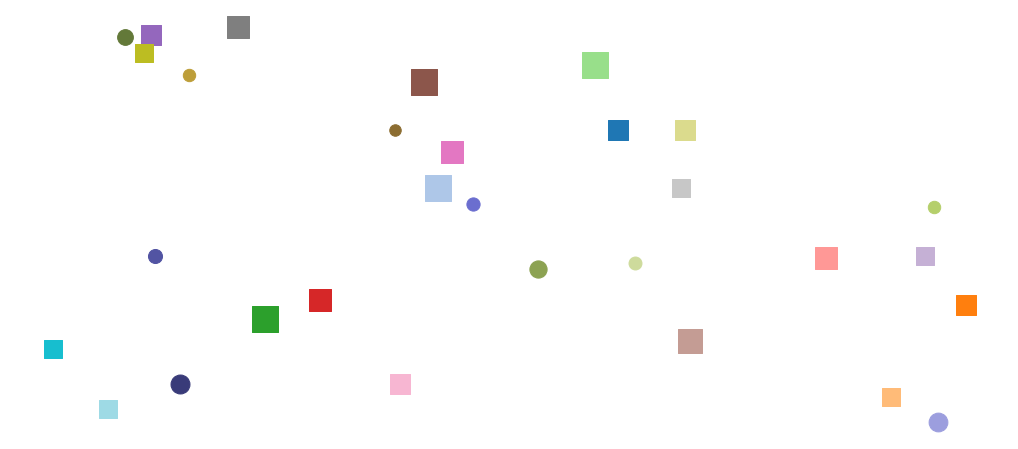

In [20]:
fig = plt.subplots(figsize=(18,8))
plt.rc('axes',edgecolor='w')

for i in instance.i:
    x=-1+2*np.random.rand()
    y=-1+2*np.random.rand()
    plt.scatter(5000*x,5000*y,s=value(instance.W[i])/5, color=cmap[i-1], marker=MV[value(instance.T[i])] )
#plt.ylim(-1,25)
XT=[str(i) for i in range(1,21)]
plt.grid()
plt.axis('off')
print(n)
plt.savefig('Airbus Cargo.png',dpi=800)